## Variational Quantum Amplitude estimation  V_2

In [1]:
import pennylane.numpy as np 
from scipy import optimize 
import pennylane as qml 

import matplotlib.pyplot as plt

In [2]:
n_qubits = 6
n = n_qubits - 1
N=2**(n_qubits - 1)
target = n_qubits-1

# Example p and theta_i
p = np.ones(32)/32
theta_i = np.sin(np.arange(32)/6)
assert len(p) == 2**n
assert len(theta_i)==2**n
a = np.sum(p * np.sin(theta_i/2)**2)

def Rotf(n, theta_i):
    for i in range(2**n):
        binary=format(i, 'b').zfill(n)
        qml.ctrl(qml.RY, range(n) , control_values=[int(x) for x in binary])(theta_i[i], wires=n)

# Set A 
def A(p,theta_i,n):
    # prepare state 
    psi = np.sqrt(p)
    overlap = psi[0]
    denominator = np.sqrt(2 + 2 * overlap)
    psi[0] += 1
    psi /= denominator

    dim = len(p)
    qml.QubitUnitary(2 * np.outer(psi, psi) - np.eye(dim), wires=range(n))
    # encode f[x] = sin^2(theta_i[x]/2)
    Rotf(n,theta_i)
    
def reflect(n_qubits, target):
    for i in range( n_qubits):
        qml.PauliX(wires =i)
    qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
    for i in range( n_qubits):
        qml.PauliX(wires =i)
        
def Q(p, theta_i, n, target):
    # reflect respect to |psi_g>|1> 
    qml.PauliZ(wires = target)
    # reflect respect to chi
    qml.adjoint(A)(p,theta_i,n)
    reflect(n+1, target)
    A(p,theta_i,n)
    
def cal_theta(n_grovers, hits, shots):
    # set range 
    m =  10**(-15)
    M = 1 - m
    thetas = [] 
    for i, n_grover in enumerate(n_grovers):

        def log_likelihood(probs):
            theta = np.arcsin(np.sqrt(probs))
            p = np.zeros_like(probs)
            for j in range(i+1):
                phi = (2 * n_grovers[j]+1) * theta
                p +=  2 * hits[j] * np.log(np.abs(np.sin(phi))) \
                    +2*(shots - hits[j])*np.log(np.abs(np.cos(phi)))
            
            return -p
        result = optimize.brute(log_likelihood, [(m, M)])
        p_cand = result[0]
        thetas.append(np.arcsin(np.sqrt(p_cand)))
        p_error = CM_error_bound(n_grovers, i, p_cand, shots)
        M = min(p_cand + 5 * p_error, 1-10**(-15))
        m = max(p_cand - 5 * p_error, 10**(-15))
    return thetas 

def CM_error_bound(n_grovers, M, p, shots):
    #Fisher_info = 0
    Fisher_info = np.sum((2*np.array(n_grovers[:M+1])+1)**2)
    Fisher_info = Fisher_info*shots / (p * (1 - p)) 
    return np.sqrt(1 / Fisher_info)

In [3]:
def make_iansatz(n_qubits):
    def inital_ansatz(params):
        
        for i in range(n_qubits):
            qml.RY(params[i],wires=i)
            # qml.RZ(params[i],wires=i)
    return inital_ansatz

def make_ansatz(n_qubits):    
    def ansatz(params):
        for i in range(n_qubits//2):
            qml.CZ(wires=(2*i, 2*i+1))
            # qml.CNOT(wires=(2*i, 2*i+1))
        for i in range(n_qubits):
            qml.RY(params[i],wires=i)
            # qml.RZ(params[i],wires=i)
        for i in range((n_qubits-1)//2):
            qml.CZ(wires=(2*i+1, 2*i+2))
            # qml.CNOT(wires=(2*i+1, 2*i+2))
        for i in range(n_qubits):
            qml.RY(params[i+n],wires=i)
            # qml.RZ(params[i+n],wires=i)
    return ansatz

iansatz=make_iansatz(n_qubits=n_qubits)
ansat=make_ansatz(n_qubits=n_qubits)

This system has used cost as
$$
cost=1-Fidelity( Q| 0 \rangle, U| 0 \rangle)
$$
So, we used CPU to simulate this system.


In [66]:

Vdev = qml.device("default.qubit", wires=n_qubits)
def vqae(layer, OC,batch, it):
    b_max = np.pi/5
    def A():
        # superposition 
        for i in range(n_qubits-1):
            qml.Hadamard(wires = i)
        # encode f(x)
        qml.RY(b_max/N, wires = target )
        for i in range(n_qubits-1):
            qml.CRY(2**(i+1) * b_max / N , wires = [i, target])
    @qml.qnode(Vdev,diff_method="backprop")
    def VC(weights):
        # rand_list=np.random.randint(2, size=n_qubits)
        # for i, x in enumerate(rand_list):
        #     if x==1:
        #         qml.PauliX(wires=i)
        # for i in range(n_qubits):
        #     qml.Hadamard(i)
        
        iansatz(weights[:n_qubits])
        for i in range(layer):
            ansat(weights[n_qubits*(2*i+1):n_qubits*(2*i+3)])
        

        
        return qml.state()
    
    @qml.qnode(Vdev,diff_method="backprop")
    def OO():
        OC(n_qubits)
        return qml.state()
    def loss( weights):
        T_state=OO()
        V_state=VC(weights)
        fidelity=qml.math.fidelity(T_state, V_state)
        # print(out/batch)
        # return (1-np.mean(out/batch))**2
        return 1-fidelity
    
    opt=qml.AdagradOptimizer(0.5)

    weights = np.random.randn(n_qubits*(2*layer+1), requires_grad=True)
    
    cost_history = []
    for it in range(it):
        weights, cost = opt.step_and_cost(loss, weights)
        print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
        cost_history.append(cost)
        if cost<-4.3:
            break
    return weights,cost

In [67]:
def Qop(n_qubits):
    b_max = np.pi/5
    def A():
        # superposition 
        for i in range(n_qubits-1):
            qml.Hadamard(wires = i)
        # encode f(x)
        qml.RY(b_max/N, wires = target )
        for i in range(n_qubits-1):
            qml.CRY(2**(i+1) * b_max / N , wires = [i, target])
            
    def reflect():
        for i in range( n_qubits):
            qml.PauliX(wires =i)
        qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
        for i in range( n_qubits):
            qml.PauliX(wires =i)
    def A_inv():
        # inverse of A 
        for i in range(n_qubits-2, -1, -1):
            qml.CRY(-2**(i+1) * b_max / N, wires = [i, target])
        qml.RY(-b_max/N, wires = target )  

        for i in range(n_qubits-1):
            qml.Hadamard(wires = i)
    def Q():
        # reflect respect to |psi_g>|1> 
        qml.PauliZ(wires = target)
        # reflect respect to chi
        A_inv()
        reflect()
        A()
    
    # start circuit 
    
    Q()


In [68]:
layer=2
batch=30
it=50
# weights,cost=vqae(layer, Qop,batch, it )

In [69]:
k=32
weight_list=[]
cost_list=[]
weights,cost=vqae(layer, Qop,batch, it )
weight_list.append(weights)
cost_list.append(cost)
def PQC(weights):
    iansatz(weights[:n_qubits])
    for i in range(layer):
        ansat(weights[n_qubits*(2*i+1):n_qubits*(2*i+3)])

for i in range(k):
    def OQ(n_qubits):
        for j in range(k):
            Qop(n_qubits)    
    weights,cost=vqae(layer, OQ,batch, it )
    weight_list.append(weights)
    cost_list.append(cost)

Step   0       Cost_L = 0.9430348
Step   1       Cost_L = 0.7980286
Step   2       Cost_L = 0.8782274
Step   3       Cost_L = 0.2320260
Step   4       Cost_L = 0.8485810
Step   5       Cost_L = 0.1252417
Step   6       Cost_L = 0.3078396
Step   7       Cost_L = 0.4382215
Step   8       Cost_L = 0.3240808
Step   9       Cost_L = 0.2613798
Step  10       Cost_L = 0.1974858
Step  11       Cost_L = 0.1657299
Step  12       Cost_L = 0.1380724
Step  13       Cost_L = 0.1242643
Step  14       Cost_L = 0.1196858
Step  15       Cost_L = 0.1341103
Step  16       Cost_L = 0.1645179
Step  17       Cost_L = 0.1628980
Step  18       Cost_L = 0.1407218
Step  19       Cost_L = 0.1056215
Step  20       Cost_L = 0.0893508
Step  21       Cost_L = 0.0737650
Step  22       Cost_L = 0.0660758
Step  23       Cost_L = 0.0590090
Step  24       Cost_L = 0.0547930
Step  25       Cost_L = 0.0509331
Step  26       Cost_L = 0.0481386
Step  27       Cost_L = 0.0455994
Step  28       Cost_L = 0.0435140
Step  29      

In [80]:
shots = 1000
# dev = qml.device('default.qubit', wires = n_qubits, shots = shots)
n_qubits = 6
y = np.pi/3
N = 2**(n_qubits-1)
target = n_qubits -1

dev = qml.device('lightning.gpu', wires = n_qubits, shots = shots)
n_grovers = [0,1,2,4,8,16,32]

analytic_result = (y / 2. - np.sin(2 * y) / 4.)/y 
print("Analytical Result:", analytic_result)

ret = []
for n_grover in n_grovers:
    @qml.qnode(device = dev)
    def circuit(n_grover):
        

        # define function 
        
        def A():
            # superposition 
            for i in range(n_qubits-1):
                qml.Hadamard(wires = i)
            # encode f(x)
            qml.RY(y/N, wires = target )
            for i in range(n_qubits-1):
                qml.CRY(2**(i+1) * y/ N , wires = [i, target])

        def reflect():
            for i in range( n_qubits):
                qml.PauliX(wires =i)
            qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
            for i in range( n_qubits):
                qml.PauliX(wires =i)
        def A_inv():
            # inverse of A 
            for i in range(n_qubits-2, -1, -1):
                qml.CRY(-2**(i+1) * y / N, wires = [i, target])
            qml.RY(-y/N, wires = target )  

            for i in range(n_qubits-1):
                qml.Hadamard(wires = i)
        def Q():
            # reflect respect to |psi_g>|1> 
            qml.PauliZ(wires = target)
            # reflect respect to chi
            A_inv()
            reflect()
            A()

        # start circuit 
        A()
        for i in range(n_grover):
            if i!=0:
                PQC(weight_list[i-1])
        return qml.sample(wires = target)
    ret.append(circuit(n_grover))
hits = []
for i in ret: 
    hits.append(np.sum(i).item()) # count number of 1s 
print(hits)

Analytical Result: 0.2932516642168279
[296, 272, 102, 102, 226, 471, 483]


Text(0.5, 0, 'depth(# of A)')

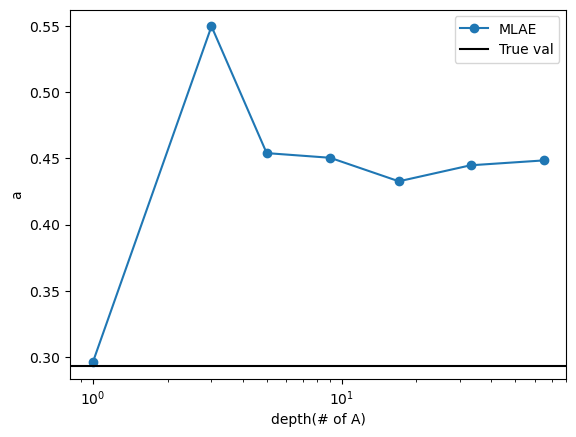

In [81]:
theta_Candidates = cal_theta(n_grovers, hits, shots=shots)
plt.plot(2*np.array(n_grovers)+1, np.sin(theta_Candidates)**2, '-o', label = 'MLAE')
plt.axhline(analytic_result, c='k', label = 'True val')
plt.legend()
plt.xscale('log')
plt.ylabel('a')
plt.xlabel('depth(# of A)')

Text(0.5, 0, 'depth(# of A)')

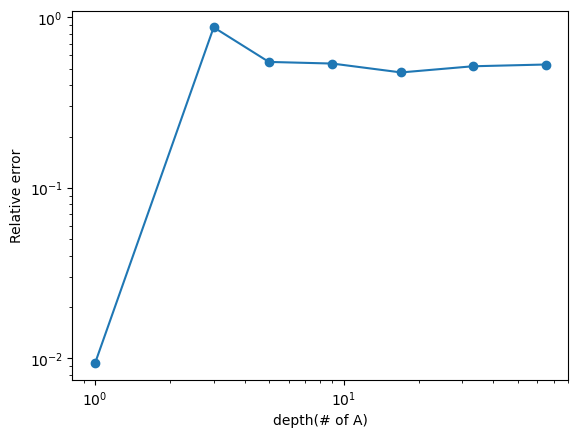

In [82]:
plt.plot(2*np.array(n_grovers)+1, np.abs(np.sin(theta_Candidates)**2-analytic_result)/analytic_result, '-o')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Relative error')
plt.xlabel('depth(# of A)')